In [1]:
import sys
import os
import re
sys.path.append('../scripts')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hp
import pickle as pkl
import itertools as it

from collections import OrderedDict, defaultdict

from sklearn.metrics import f1_score, precision_score, recall_score,\
                            average_precision_score, roc_auc_score,\
                            roc_curve, precision_recall_curve, confusion_matrix,\
                            accuracy_score, classification_report

from IPython.core.interactiveshell import InteractiveShell
from matplotlib import rcParams
from importlib import reload
from model_generator import deep_er_model_generator
pd.options.display.max_colwidth = 1000

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/home/paperspace/anaconda3/envs/python-36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load data 

In [2]:
reload(hp)

with open('../data/converted/dblp-scholar-reduced/glove-300.map', 'rb') as f:
    map = pkl.load(f)

data_dir = os.path.join('..','data')
source_dir = os.path.join(data_dir,'split','dblp-scholar-reduced')
data = hp.load_data(source_dir)

datasets = ['train_1', 'val_1', 'test_1', 'train_2', 'val_2', 'test_2']

for data_name in datasets:
    data[data_name] = data[data_name].fillna(0)

doc_freqs_1, doc_freqs_2 = hp.get_document_frequencies('../data/converted/dblp-scholar-reduced/', mapping=map)
nan_idx = map['word2idx']['NaN']

# Generate model

In [3]:
histories = dict(acc=list(), val_acc=list(), loss=list(), val_loss=list())
model, X_train, X_val, X_test, y_train, y_val, y_test = \
deep_er_model_generator(data,
                        embedding_file = '../data/converted/dblp-scholar-reduced/glove-300.matrix.npy',
                        text_columns = ['title', 'authors', 'venue'],
                        numeric_columns = ['year'],
                        text_nan_idx=nan_idx,
                        num_nan_val=0,
                        text_sim_metrics=[],
                        text_compositions=['bi_lstm'],
                        numeric_sim_metrics=['min_max_ratio', 'unscaled_inverse_lp', 'scaled_inverse_lp'],
                        dense_nodes=[32, 16],
                        document_frequencies=(doc_freqs_1, doc_freqs_2),
                        idf_smoothing=2,
                        make_isna=True,
                        lstm_args=dict(units=25, dropout=0, recurrent_dropout=0),
                        batch_norm=True,
                        dropout=0.5)

Number of inputs to dense layer: 92


# Crash recovery 

In [4]:
model.load_weights('../data/models/dblp-scholar-base-2-num-null')
df_hist = pd.read_csv('../data/histories/dblp-scholar-base-2-num-null.csv')

histories['acc'] = list(df_hist['acc'].values)
histories['val_acc'] = list(df_hist['val_acc'].values)
histories['loss'] = list(df_hist['loss'].values)
histories['val_loss'] = list(df_hist['val_loss'].values)

# Train model 

In [61]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=1, batch_size=8192,
                    validation_data=(X_val, y_val),
                    shuffle=True)

histories['acc'].extend(history.history['acc'])
histories['val_acc'].extend(history.history['val_acc'])
histories['loss'].extend(history.history['loss'])
histories['val_loss'].extend(history.history['val_loss'])

Train on 432038 samples, validate on 54004 samples
Epoch 1/1
432038/432038 [==============================] - 157s 363us/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.0034 - val_acc: 0.9996


# Learning curves

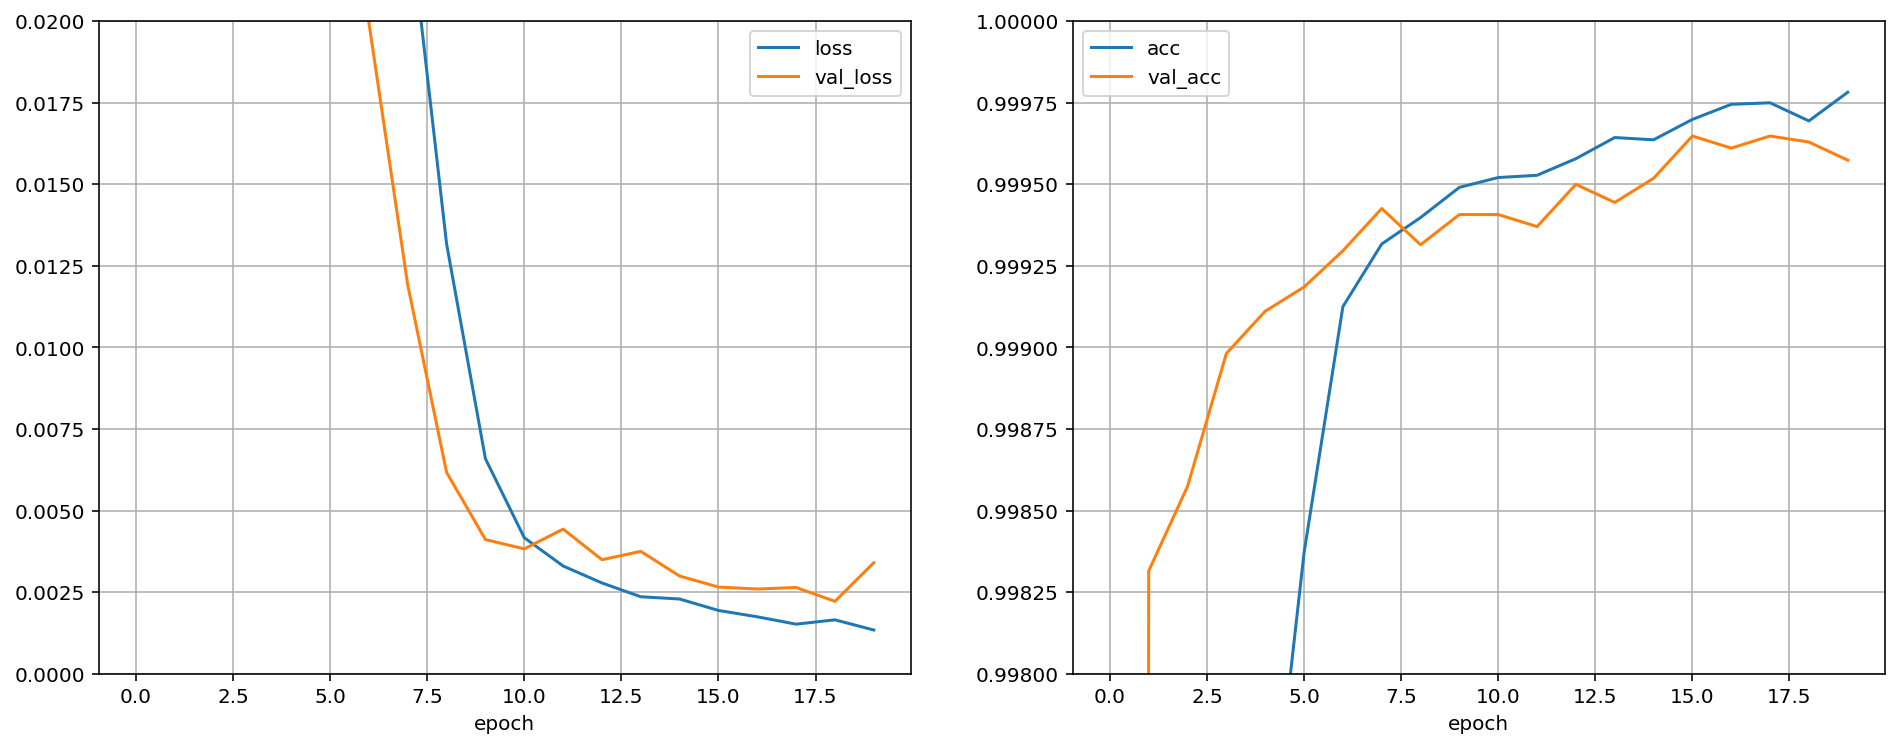

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].plot(histories['loss'], label='loss')
axes[0].plot(histories['val_loss'], label='val_loss')
axes[0].set_ylim(0, 0.02)
axes[1].plot(histories['acc'], label='acc')
axes[1].plot(histories['val_acc'], label='val_acc')
axes[1].set_ylim(0.998, 1)

for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set(xlabel='epoch')

# Evaluate model 

In [57]:
y_val_pred = model.predict(X_val, batch_size=8192)[:,1]
y_val_ = data['val_y'].values.squeeze()
print(classification_report(y_val_, y_val_pred >= 0.5))
print(confusion_matrix(y_val_, y_val_pred >= 0.5))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     53474
          1       1.00      0.96      0.98       530

avg / total       1.00      1.00      1.00     54004

[[53473     1]
 [   19   511]]


In [58]:
mapping = map.copy()
bool_mask = (y_val_ == 1) & ~(y_val_pred >= 0.5)
columns = ['title', 'authors', 'venue']
df_examine = hp.examine_data(data['val_1'], data['val_2'], columns, bool_mask, mapping)
df_examine.sample(5)

,id1,title,authors,venue,year,id2,title,authors,venue,year
26814,conf/vldb/GyssensL97,foundation for databases,gyssens lakshmanan,vldb,1997,CfujBHjOpPAJ,foundation for in dayal gray pmd nishio eds,gyssens lvs lakshmanan,nan,1997.0
1026,conf/vldb/AgrawalS94,fast algorithms for mining association rules in large databases,agrawal srikant,vldb,1994,3MzTom30SiMJ,fastalgorithmsformining association rules,rar srikant,of the vldb conference santiago chile september,0.0
36202,conf/sigmod/PoosalaIHS96,improved histograms for selectivity estimation of range predicates,poosala ioannidis haas shekita,sigmod conference,1996,4eUqHKdkGNoJ,ye loannidis pj haas and ej improved histograms for selectivity estimation of range,poosala,proceedings of the 1996 acm international conference on,0.0
31899,conf/vldb/SrikantA95,mining generalized association rules,srikant agrawal,vldb,1995,kAi6HssDySgJ,fast for mining assoiciation rules,agrawal srikant,the 20th vldb,0.0
9403,conf/sigmod/BratsbergT00,tutorial designing an ultra highly available dbms,nan,nan,2000,af50lhGnD8gJ,an ultra highly available dbms,so hvasshovd se bratsberg torbjoernsen,nan,0.0


# Save model and histories 

In [59]:
pd.DataFrame(histories).to_csv('../data/histories/dblp-scholar-base-2-num-null.csv', index=False)
model.save_weights('../data/models/dblp-scholar-base-2-num-null')

# Test model 

In [60]:
y_test_pred = model.predict(X_test, batch_size=8192)[:,1]
y_test_ = data['test_y'].values.squeeze()
print(classification_report(y_test_, y_test_pred >= 0.5, digits=5))
print(confusion_matrix(y_test_, y_test_pred >= 0.5))

             precision    recall  f1-score   support

          0    0.99972   0.99994   0.99983     53467
          1    0.99430   0.97212   0.98308       538

avg / total    0.99967   0.99967   0.99966     54005

[[53464     3]
 [   15   523]]
